Import required libraries

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

Load and preprocess the data

In [2]:
def load_data(visitors_file, places_file):
    visitors_df = pd.read_csv(visitors_file)
    places_df = pd.read_csv(places_file)
    
    visitors_df['Preferred Activities'] = visitors_df['Preferred Activities'].apply(eval)
    visitors_df['Bucket list destinations Sri Lanka'] = visitors_df['Bucket list destinations Sri Lanka'].apply(eval)
    
    return visitors_df, places_df

visitors_file = 'u.csv'
places_file = 'p.csv'
visitors_df, places_df = load_data(visitors_file, places_file)

print("Data loaded successfully.")
print(f"Number of visitors: {len(visitors_df)}")
print(f"Number of places: {len(places_df)}")

Data loaded successfully.
Number of visitors: 10000
Number of places: 411


Data Diagnostics

In [3]:
print("\nData Diagnostics:")
print("Sample of Preferred Activities:", visitors_df['Preferred Activities'].iloc[0])
print("Sample of Bucket list destinations:", visitors_df['Bucket list destinations Sri Lanka'].iloc[0])
print("Number of unique activities:", len(set([item for sublist in visitors_df['Preferred Activities'] for item in sublist])))
print("Number of unique destinations:", len(set([item for sublist in visitors_df['Bucket list destinations Sri Lanka'] for item in sublist])))


Data Diagnostics:
Sample of Preferred Activities: ['cycling', 'historical monuments', 'village homestays']
Sample of Bucket list destinations: ['Polonnaruwa', 'Hatton', 'Anuradhapura', 'Ella', 'Haputale']
Number of unique activities: 68
Number of unique destinations: 157


Data Preparation

In [4]:
def prepare_data(visitors_df, places_df):
    activity_mlb = MultiLabelBinarizer()
    user_activities = activity_mlb.fit_transform(visitors_df['Preferred Activities'])
    
    place_mlb = MultiLabelBinarizer()
    user_places = place_mlb.fit_transform(visitors_df['Bucket list destinations Sri Lanka'])
    
    scaler = StandardScaler()
    user_activities_scaled = scaler.fit_transform(user_activities)
    
    return user_activities_scaled, user_places, activity_mlb, place_mlb

user_activities, user_places, activity_mlb, place_mlb = prepare_data(visitors_df, places_df)

print("\nData prepared for model.")
print(f"Number of unique activities: {len(activity_mlb.classes_)}")
print(f"Number of unique places: {len(place_mlb.classes_)}")
print(f"Shape of user_activities: {user_activities.shape}")
print(f"Shape of user_places: {user_places.shape}")

print(f"Number of zero vectors in user_activities: {np.sum(np.all(user_activities == 0, axis=1))}")
print(f"Number of zero vectors in user_places: {np.sum(np.all(user_places == 0, axis=1))}")


Data prepared for model.
Number of unique activities: 68
Number of unique places: 157
Shape of user_activities: (10000, 68)
Shape of user_places: (10000, 157)
Number of zero vectors in user_activities: 0
Number of zero vectors in user_places: 0


Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(user_activities, user_places, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("\nData split into train, validation, and test sets.")
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Data split into train, validation, and test sets.
Training set size: 6400
Validation set size: 1600
Test set size: 2000


Model Creation

In [6]:
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(output_dim, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_model(X_train.shape[1], y_train.shape[1])
model.summary()

d:\install\envs\ml_workshop\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 157)            │        10,205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,813 (276.61 KB)

 Trainable params: 69,917 (273.11 KB)

 Non-trainable params: 896 (3.50 KB)

Training the Model

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

print("\nModel training completed.")

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.0107 - loss: 0.7332 - val_accuracy: 0.0512 - val_loss: 0.2980 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0188 - loss: 0.2554 - val_accuracy: 0.0431 - val_loss: 0.1327 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0305 - loss: 0.1455 - val_accuracy: 0.0425 - val_loss: 0.1260 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0332 - loss: 0.1386 - val_accuracy: 0.0525 - val_loss: 0.1224 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0398 - loss: 0.1336 - val_accuracy: 0.0606 - val_loss: 0.1183 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0469 - loss: 0.1304 - val_accuracy: 0.0750 - val_loss: 0.1136 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0521 - loss: 0.

Evaluate model

In [8]:

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=place_mlb.classes_, zero_division=1))

f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=1)
print(f"Weighted F1 Score: {f1:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
                                              precision    recall  f1-score   support

                              Laxapana Falls       1.00      0.00      0.00        20
                                    Ahangama       0.25      0.06      0.10        33
                                   Ahungalla       0.20      0.04      0.06        27
                                 Ambalangoda       1.00      0.00      0.00        48
                   Ambalangoda Mask Workshop       0.67      0.21      0.32        38
                            Ambuluwawa Tower       0.47      0.22      0.30        36
                       Anawilundawa Wetlands       0.17      0.04      0.06        28
                                 Anuradapura       0.66      0.37      0.47        52
                                Anuradhapura       0.62      0.08      0.15       154
                  Arankelle Forest Monastery       1.00      0.09      0.16 

Visualize training progress

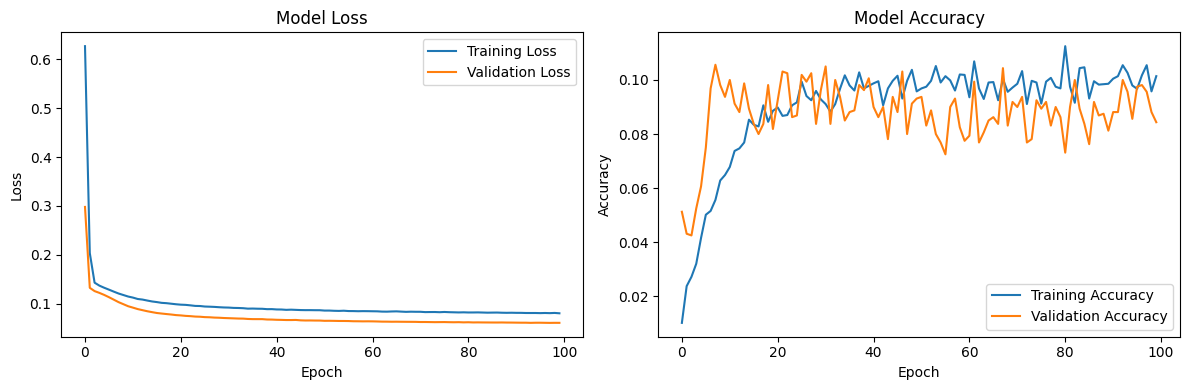

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Additional diagnostics

In [12]:
print("\nAdditional Diagnostics:")
print(f"Max value in predictions: {np.max(y_pred)}")
print(f"Min value in predictions: {np.min(y_pred)}")
print(f"Mean value in predictions: {np.mean(y_pred)}")
print(f"Number of non-zero predictions: {np.sum(y_pred > 0)}")
print(f"Number of predictions above 0.5 threshold: {np.sum(y_pred > 0.5)}")

if np.all(y_pred == y_pred[0]):
    print("Warning: All predictions are the same!")

if np.isnan(y_pred).any() or np.isinf(y_pred).any():
    print("Warning: Predictions contain NaN or infinity values!")


Additional Diagnostics:
Max value in predictions: 0.9655964970588684
Min value in predictions: 1.1678962241745694e-09
Mean value in predictions: 0.026605254039168358
Number of non-zero predictions: 314000
Number of predictions above 0.5 threshold: 2408


Sample predictions

In [13]:
print("\nSample predictions:")
for i in range(5):
    print(f"Sample {i+1}:")
    print("True labels:", y_test[i].nonzero()[0])
    print("Predicted probabilities:", y_pred[i][y_pred[i] > 0])
    print("Predicted labels:", y_pred_classes[i].nonzero()[0])
    print()


Sample predictions:
Sample 1:
True labels: [  1   2  10  81 105]
Predicted probabilities: [1.6336418e-03 3.1557006e-01 2.0952815e-01 2.0364594e-02 5.5883080e-04
 3.5280291e-06 2.1693214e-04 1.1051353e-05 7.7813384e-03 2.0033811e-04
 2.8404748e-01 9.6551346e-04 1.0421834e-03 1.3038870e-03 4.1645058e-04
 3.5168178e-04 4.2920723e-04 2.5560230e-04 2.1201263e-03 5.3551374e-03
 3.0476606e-01 1.6644949e-01 1.3940312e-03 1.0703462e-03 3.2679830e-04
 2.1046855e-02 1.1395525e-02 4.6961891e-04 1.9105808e-01 1.5614554e-02
 2.7686285e-04 8.0984959e-04 1.4776560e-03 1.7176151e-05 1.4591585e-03
 5.6676462e-04 1.2335270e-04 4.4451054e-02 1.0078374e-04 3.9458918e-04
 1.1817669e-03 5.0034566e-04 1.2811398e-02 1.4607458e-02 1.2662070e-03
 2.0351130e-05 4.1730996e-04 2.1647342e-02 9.7793136e-06 3.8051549e-02
 1.6619839e-02 9.3926573e-03 2.2526886e-01 1.5739126e-02 2.2993030e-03
 6.2139030e-03 1.3674357e-03 4.7581797e-03 7.7187218e-02 4.3513803e-05
 4.6935268e-03 3.3936547e-03 7.7394228e-03 1.9479118e-01 

Recommendations

In [14]:
def get_recommendations(user_activities, model, place_mlb, places_df, top_n=5):
    predictions = model.predict(user_activities.reshape(1, -1))
    
    top_indices = predictions.argsort()[0][::-1][:top_n]
    
    recommended_places = place_mlb.classes_[top_indices]

    recommendations = places_df[places_df['name'].isin(recommended_places)]
    
    top_n_adjusted = min(len(recommendations), top_n)

    recommendations = recommendations.head(top_n_adjusted)
    recommendations['score'] = predictions[0][top_indices][:top_n_adjusted]
    
    return recommendations.sort_values('score', ascending=False)

Get recommendations for a sample user

In [15]:
user_id = 354
user_index = visitors_df[visitors_df['User ID'] == user_id].index[0]
user_activity_vector = user_activities[user_index]

recommendations = get_recommendations(user_activity_vector, model, place_mlb, places_df)

print(f"\nTop 5 recommendations for User ID {user_id}:")
print(recommendations[['name', 'formatted_address', 'rating', 'score']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Top 5 recommendations for User ID 354:
             name   formatted_address  rating     score
1   Mirissa Beach  Mirissa, Sri Lanka     4.6  0.554260
94     Kandy Lake    Kandy, Sri Lanka     4.7  0.524235


Save Model

In [16]:
model.save('recommendation_model.h5')
print("Model saved successfully as 'recommendation_model.h5'")

Model saved successfully as 'recommendation_model.h5'
